In [1]:
import numpy as np
from matplotlib import pyplot as plt
import timeit

%matplotlib inline

import h5py
from pathlib import Path
from jobmanager import *

In [2]:
config = dict(
              mcmc_routine='quantum_cython_mcmc',
              N_steps = 10**3,
              N_system = np.array([16,32,64,128]),
              mu = 0,
              beta = np.linspace(0.1,1.5,30),
              V=-1,
              U=np.linspace(0,3,30),
              alpha=1.5,
              return_names = True,
              #this is necessary for hd5 to know how to save it
              loop_over = np.array(['N_system', 'U', 'beta'], dtype=h5py.special_dtype(vlen=str)),
            )

working_dir = Path('./data/small_quantum_run')
setup_mcmc(config, working_dir)

config = read_config_file(working_dir)
config

INFO:jobmanager:Working in: data/small_quantum_run
INFO:jobmanager:Directory exists, skipping setup step
#!/usr/bin/env bash
#PBS -N small_quantum_run
#PBS -lselect=1:ncpus=1:mem=4gb:avx=true
#PBS -lwalltime=24:00:00
#PBS -J 1-3600

echo ------------------------------------------------------
echo -n 'Job is running on node '; cat $PBS_NODEFILE
echo ------------------------------------------------------
echo PBS: qsub is running on $PBS_O_HOST
echo PBS: originating queue is $PBS_O_QUEUE
echo PBS: executing queue is $PBS_QUEUE
echo PBS: working directory is $PBS_O_WORKDIR
echo PBS: execution mode is $PBS_ENVIRONMENT
echo PBS: job identifier is $PBS_JOBID
echo PBS: job name is $PBS_JOBNAME
echo PBS: node file is $PBS_NODEFILE
echo PBS: current home directory is $PBS_O_HOME
echo PBS: PATH = $PBS_O_PATH
echo ------------------------------------------------------

module load intel-suite anaconda3/personal
. /home/tch14/anaconda3/etc/profile.d/conda.sh
conda activate idp

cd $HOME/Falicok-Ki

{'mcmc_routine': 'quantum_cython_mcmc',
 'N_steps': 1000,
 'N_system': array([ 16,  32,  64, 128]),
 'mu': 0,
 'beta': array([0.1       , 0.14827586, 0.19655172, 0.24482759, 0.29310345,
        0.34137931, 0.38965517, 0.43793103, 0.4862069 , 0.53448276,
        0.58275862, 0.63103448, 0.67931034, 0.72758621, 0.77586207,
        0.82413793, 0.87241379, 0.92068966, 0.96896552, 1.01724138,
        1.06551724, 1.1137931 , 1.16206897, 1.21034483, 1.25862069,
        1.30689655, 1.35517241, 1.40344828, 1.45172414, 1.5       ]),
 'V': -1,
 'U': array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
        0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
        1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
        1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
        2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
        2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.        ]),
 'alpha': 1.5,
 'return_names': True,
 'loop_ov

In [3]:
config = read_config_file(working_dir)
incomplete = job_completion(working_dir)

print(working_dir)
print(f'Remaining: {len(incomplete)} Total: {total_jobs(config)}\n')

data/small_quantum_run
Remaining: 6 Total: 3600



In [4]:
gather_mcmc(working_dir)

INFO:jobmanager:Number of Jobs to copy in: 6
INFO:jobmanager:Job IDs: [2517 2518 2519 2520 2521 2522]...
INFO:jobmanager:missing : [2517, 2518, 2519, 2520, 2521, 2522]
INFO:jobmanager:Jobs attempted this time: 6
INFO:jobmanager:Overall completion: 3594 / 3600
INFO:jobmanager:File size: 0.12Gb


[2517, 2518, 2519, 2520, 2521, 2522]

['classical_energies', 'magnetisations', 'numbers', 'quantum_energies']
{'mcmc_routine': 'quantum_cython_mcmc', 'N_steps': 1000, 'N_system': array([ 16,  32,  64, 128]), 'mu': 0, 'beta': array([0.1       , 0.14827586, 0.19655172, 0.24482759, 0.29310345,
       0.34137931, 0.38965517, 0.43793103, 0.4862069 , 0.53448276,
       0.58275862, 0.63103448, 0.67931034, 0.72758621, 0.77586207,
       0.82413793, 0.87241379, 0.92068966, 0.96896552, 1.01724138,
       1.06551724, 1.1137931 , 1.16206897, 1.21034483, 1.25862069,
       1.30689655, 1.35517241, 1.40344828, 1.45172414, 1.5       ]), 'V': -1, 'U': array([0.        , 0.10344828, 0.20689655, 0.31034483, 0.4137931 ,
       0.51724138, 0.62068966, 0.72413793, 0.82758621, 0.93103448,
       1.03448276, 1.13793103, 1.24137931, 1.34482759, 1.44827586,
       1.55172414, 1.65517241, 1.75862069, 1.86206897, 1.96551724,
       2.06896552, 2.17241379, 2.27586207, 2.37931034, 2.48275862,
       2.5862069 , 2.68965517, 2.79310345, 2.89655172, 3.   

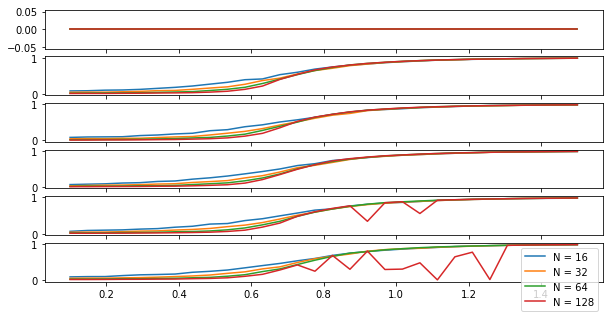

In [5]:
#%%time
result_filename = working_dir / 'results.hdf5'

with h5py.File(result_filename, 'r') as data:
    print(list(data.keys()))
    print(dict(data.attrs))
    shape = list(map(lambda key : len(data.attrs[key]), data.attrs['loop_over'])) + [data.attrs['N_steps'],]
    print(shape)

    N_systems = data.attrs['N_system']
    Us = data.attrs['U']
    betas = data.attrs['beta']
    
    skip = 100
    
    key = 'magnetisations'
    Us_to_plot = [0, 5, 10, 15, 20, 29]
    f, axes = plt.subplots(len(Us_to_plot), figsize = (10,5))
    
    for ax, U_index in zip(axes, Us_to_plot):
        for i, N_system in enumerate(N_systems):
            small_slice = (i, U_index, ..., slice(skip,None))
            mean = (data[key][small_slice]**2).mean(axis = -1) / N_system**2
            ax.plot(betas, mean, label = f'N = {N_system}')
        
ax.legend()